In [26]:
import pandas as pd
import numpy as np
import math

In [27]:
!pip install sklearn

You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [39]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold

In [29]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Flatten,MaxPooling2D,Dropout,Dense,Activation,BatchNormalization

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [31]:
from tqdm import tqdm
from tabulate import tabulate

In [32]:
os.listdir('Hamza_Custom_Data/CT_Scan/Covid/CT_COVID')

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'Hamza_Custom_Data/CT_Scan/Covid/CT_COVID'

In [ ]:
# selecting random number of images from multiple folders and copying it to the destination folder

import os
import shutil
import glob
import random
ctscan_covid_data = random.sample(glob.glob("Custom_Data/CT_Scan/Covid/CT_COVID/*.png"), 330)
ctscan_normal_data = random.sample(glob.glob("Custom_Data/CT_Scan/Normal/CT_nonCOVID/*"), 330)

ultrasound_covid_data = random.sample(glob.glob("Custom_Data/ultrasound/Covid/*"), 330)
ultrasound_normal_data = random.sample(glob.glob("Custom_Data/ultrasound/Normal/*.jpg"), 330)

xray_covid_data = random.sample(glob.glob("Custom_Data/X_ray/Covid/*.png"), 330)
xray_normal_data = random.sample(glob.glob("Custom_Data/X_ray/Normal/*.png"), 330)

# ctscan_covid_data = random.sample(glob.glob("Hamza_Custom_Data/CT_Scan/Covid/*.png"), 330)
# ctscan_normal_data = random.sample(glob.glob("Hamza_Custom_Data/CT_Scan/Normal/*"), 330)   

# ultrasound_covid_data = random.sample(glob.glob("Hamza_Custom_Data/Ultra_Sound/Covid/*"), 330)
# ultrasound_normal_data = random.sample(glob.glob("Hamza_Custom_Data/Ultra_Sound/Normal/*.jpg"), 330)

# xray_covid_data = random.sample(glob.glob("Hamza_Custom_Data/X_Ray/Covid/*.png"), 330)
# xray_normal_data = random.sample(glob.glob("Hamza_Custom_Data/X_Ray/Normal/*.png"), 330)

covid_list=[ctscan_covid_data,ultrasound_covid_data,xray_covid_data]

normal_list = [ctscan_normal_data, ultrasound_normal_data,xray_normal_data]

if os.path.isdir('Data/Covid'):
    shutil.rmtree('Data/Covid')
    
if os.path.isdir('Data/Normal'):
    shutil.rmtree('Data/Normal')
    
# if os.path.isdir('/content/drive/MyDrive/Data/X_Ray'):
#     shutil.rmtree('/content/drive/MyDrive/Data/X_Ray')

for data in covid_list:
    dest = 'Data/Covid'
    if not os.path.isdir('Data/Covid'):
        os.makedirs(dest)
    for imgs in data:
        shutil.copy(imgs, dest)

for data in normal_list:
    dest = 'Data/Normal' 
    if not os.path.isdir('Data/Normal'):
          os.makedirs(dest)
    for imgs in data:
        shutil.copy(imgs, dest)

In [ ]:
class Dataset:
    def __init__(self, data_root: str, *, test_size: float, img_size: int, seed: int = 0) -> None:
        self.label2index = {}
        self.index2label = {}
        
        # Discover the class label names.
        class_labels = os.listdir(data_root)
        self.nclasses = len(class_labels)
        X, y = [], []
        
        for label_index, label in enumerate(class_labels):
            # Load the images for this class label.
            self.label2index[label_index] = label
            self.index2label[label] = label_index
            
            img_names = os.listdir(os.path.join(data_root, label))
            for img_name in img_names:
                img_path = os.path.join(data_root, label, img_name)
                img = load_img(img_path, target_size=(img_size, img_size, 3))
                X.append(img_to_array(img))
                y.append(label_index)
        
        X = np.array(X)
        y = np.array(y)
        one_hot_y = to_categorical(y, num_classes=self.nclasses)
        
        # Make a stratified split.
        self.X, self.X_test, self.labels, self.labels_test, self.y, self.y_test = train_test_split(
            X, y, one_hot_y, test_size=test_size, random_state=seed, stratify=y)

In [ ]:
# 660 * 0.7 = 462 
# X shape in 3 dimensions
# Y has 2 classes (Covid, Normal)
import os
import shutil
import glob
import random
data = Dataset("Data/", test_size=0.3, img_size=224)
print(data.X.shape, data.y.shape)

# Normal = Dataset("/content/drive/MyDrive/Data/", test_size=0.3, img_size=224)
# print(Normal.X.shape, Normal.y.shape)

(1386, 224, 224, 3) (1386, 2)


In [ ]:
# feature extractor model resnet 101 v2
model = hub.KerasLayer("https://tfhub.dev/google/bit/m-r101x1/1", trainable=False)

In [ ]:
covid_embedding = model(data.X)
covid_test_embedding = model(data.X_test)
print(covid_embedding.shape, covid_test_embedding.shape)

(1386, 2048) (594, 2048)


In [ ]:
# feature extractor model mobinet v2
model_mobinet = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4", trainable=False)

In [ ]:
covid_embedding_mob = model_mobinet(data.X)
covid_test_embedding_mob = model_mobinet(data.X_test)
print(covid_embedding_mob.shape, covid_test_embedding_mob.shape)

(1386, 1280) (594, 1280)


In [ ]:
def make_model(nclasses: int):
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (3,3), padding='same', input_shape=(2,2,512), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(24, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(32, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(48, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(nclasses, activation="sigmoid"))
    #model.summary()
    return model

In [ ]:
def evaluate_model(nclasses, X, y, X_test, y_test, *, epochs: int, batch_size: int, learning_rate: float, 
                   **model_params) -> tuple:
    
    # Math to compute the learning rate schedule. We will divide our
    # learning rate by a factor of 10 every 30% of the optimizer's
    # total steps.
    steps_per_epoch = math.ceil(len(X) / batch_size)
    third_of_total_steps = math.floor(epochs * steps_per_epoch / 3)
    
    # Make and compile the model.
    #model = model_maker(nclasses, **model_params)
    model = make_model(nclasses)
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                learning_rate,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = model.fit(X, y, batch_size=batch_size, epochs=epochs, verbose=0)
    _, train_acc = model.evaluate(X, y, batch_size=batch_size, verbose=0)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    return model, history, train_acc, test_acc

In [ ]:
def cv_evaluate_model(
    X, y, labels, *, nfolds: int, nrepeats: int, epochs: int, batch_size: int,
    learning_rate: float, model_maker, verbose: bool = True, seed: int = 0,
    **model_params
) -> dict:
    """
    Performs `nfolds` cross-validated training and evaluation of a
    model hyperparameter configuration. Returns a dictionary of
    statistics about the outcome of the cross-validated experiment.
    """
    _, nclasses = y.shape
    train_accs, test_accs = [], []
    
    # Train and evaluate the model for each fold.
    for train_index, test_index in tqdm(
        RepeatedStratifiedKFold(
            n_splits=nfolds, n_repeats=nrepeats, random_state=seed
        ).split(X, labels),
        total=nfolds*nrepeats, disable=not verbose
    ):
        
        # Select the data for this fold.
        X_train_fold = tf.gather(X, train_index) 
        y_train_fold = tf.gather(y, train_index)
        X_test_fold = tf.gather(X, test_index)
        y_test_fold = tf.gather(y, test_index)
        
        # Train and evaluate the model.
        _, _, train_acc, test_acc = evaluate_model(
            nclasses,
            X_train_fold,
            y_train_fold,
            X_test_fold,
            y_test_fold,
            epochs=epochs,
            batch_size=batch_size,
            learning_rate=learning_rate,
            model_maker=model_maker,
            **model_params
        )
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    
    # Aggregate.
    results = {
        "train_mean": np.mean(train_accs),
        "train_std": np.std(train_accs),
        "test_mean": np.mean(test_accs),
        "test_std": np.std(test_accs)
    }
    
    # Report.
    if verbose:
        print(
            tabulate(
                [
                    ["Train", results["train_mean"], results["train_std"]],
                    ["Test", results["test_mean"], results["test_std"]]
                ],
                headers=["Set", "Accuracy", "Standard Deviation"]
            )
        )
    
    return results

In [ ]:
X_list = [covid_embedding]
y_list = [data.y]
data_labels = [data.labels]

In [ ]:
covid_embedding.shape

TensorShape([1386, 2048])

In [ ]:
# Chaning shape for CNN2D
# for 2048 - > [-1,2,2,512]
# for 1280 - > [-1,2,2,320]

covid_embedding2d = tf.reshape(covid_embedding, [-1,2,2,512])
print(covid_embedding2d.shape)

covid_embedding2d_mob = tf.reshape(covid_embedding_mob, [-1,2,2,320])
print(covid_embedding2d_mob.shape)

X_list = [covid_embedding2d]
X_list_mob = [covid_embedding2d_mob]

(1386, 2, 2, 512)
(1386, 2, 2, 320)


### Model Results 

In [ ]:
n_class = y_list[0].shape[1]
model_cnn = make_model(n_class)
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2, 2, 16)          73744     
                                                                 
 batch_normalization (BatchN  (None, 2, 2, 16)         64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 2, 2, 16)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 24)          3480      
                                                                 
 batch_normalization_1 (Batc  (None, 2, 2, 24)         96        
 hNormalization)                                                 
                                                        

### Results with Resnet 101 v2

In [ ]:
model_evaluate_params = {
    "X": X_list[0],
    "y": y_list[0],
    "labels": data_labels[0],
    "nfolds": 10,
    "nrepeats": 3,
    "model_maker": make_model,
    "epochs": 200,
    "batch_size": 32,
    "verbose": False,
    "learning_rate": 3e-3 #0.003
}

In [ ]:
_ = cv_evaluate_model(
    **{
        **model_evaluate_params,
        "verbose": True
    }
)

  3%|██▋                                                                             | 1/30 [03:24<1:39:04, 205.00s/it]


KeyboardInterrupt: 

### Results with Mobinet v2

In [ ]:
model_evaluate_params_mob = {
    "X": X_list_mob[0],
    "y": y_list[0],
    "labels": data_labels[0],
    "nfolds": 10,
    "nrepeats": 3,
    "model_maker": make_model,
    "epochs": 200,
    "batch_size": 32,
    "verbose": False,
    "learning_rate": 3e-3 #0.003
}

In [ ]:
_ = cv_evaluate_model(
    **{
        **model_evaluate_params_mob,
        "verbose": True
    }
)

100%|███████████████████████████████████████████████████████████████████████████████| 30/30 [1:00:55<00:00, 121.86s/it]

Set      Accuracy    Standard Deviation
-----  ----------  --------------------
Train    0.99984            0.000599645
Test     0.839582           0.0335461


### Graph Method for Resnet 101 v2

In [ ]:
X_value = X_list[0]
y_value = y_list[0]
labels = data_labels[0]
train_accs, test_accs = [], []

nclasses = y_value.shape[1]
nfolds = 10
nrepeats = 3
epochs = 200
batch_size = 32
learning_rate = 3e-3 #0.003
verbose = True

# Train and evaluate the model for each fold.
for train_index, test_index in tqdm(
    RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state = 0).split(X_value, labels), \
    total = nfolds*nrepeats, disable = not True #(verbose - True)
):

    # Select the data for this fold.
    X_train = tf.gather(X_value, train_index) 
    y_train = tf.gather(y_value, train_index)
    X_test = tf.gather(X_value, test_index)
    y_test = tf.gather(y_value, test_index)
    
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    #Define Model
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (3,3), padding='same', input_shape=(2,2,512), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(24, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(32, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(48, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(nclasses, activation="sigmoid"))

    #Learning Rate
    steps_per_epoch = math.ceil(len(X_train) / batch_size)
    third_of_total_steps = math.floor(epochs * steps_per_epoch / 3)
    
    # Train and evaluate the model.
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                learning_rate,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = (model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, verbose=1, \
                         validation_data=(X_test, y_test)))
    train_loss, train_acc = model.evaluate(X_train, y_train, batch_size = batch_size, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size = batch_size, verbose=0)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

# Report.
if verbose:
    print(
        tabulate(
            [
                ["Train", results["Train_Acc"], results["Train_std"]],
                ["Test", results["Test_Acc"], results["Test_std"]]
            ],
            headers=["Set", "Accuracy", "Standard Deviation"]
        )
    )

  0%|          | 0/30 [00:00<?, ?it/s]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 4s 33ms/step - loss: 0.7530 - accuracy: 0.5774 - val_loss: 0.6581 - val_accuracy: 0.7482
Epoch 2/200
39/39 [==============================] - 1s 18ms/step - loss: 0.4661 - accuracy: 0.7843 - val_loss: 0.6209 - val_accuracy: 0.7050
Epoch 3/200
39/39 [==============================] - 1s 18ms/step - loss: 0.4214 - accuracy: 0.8180 - val_loss: 0.5561 - val_accuracy: 0.6691
Epoch 4/200
39/39 [==============================] - 1s 18ms/step - loss: 0.3518 - accuracy: 0.8557 - val_loss: 0.4369 - val_accuracy: 0.7986
Epoch 5/200
39/39 [==============================] - 1s 14ms/step - loss: 0.2931 - accuracy: 0.8805 - val_loss: 0.4615 - val_accuracy: 0.7338
Epoch 6/200
39/39 [==============================] - 1s 17ms/step - loss: 0.2487 - accuracy: 0.8990 - val_loss: 0.3028 - val_accuracy: 0.8345
Epoch 7/200
39/39 [==============================] - 0s 12ms/step - loss: 0.2275 - accuracy: 0

  3%|▎         | 1/30 [02:08<1:01:52, 128.02s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 30ms/step - loss: 0.6874 - accuracy: 0.5966 - val_loss: 0.6362 - val_accuracy: 0.6763
Epoch 2/200
39/39 [==============================] - 1s 19ms/step - loss: 0.4719 - accuracy: 0.7763 - val_loss: 0.6266 - val_accuracy: 0.6259
Epoch 3/200
39/39 [==============================] - 1s 20ms/step - loss: 0.3875 - accuracy: 0.8356 - val_loss: 0.5843 - val_accuracy: 0.6403
Epoch 4/200
39/39 [==============================] - 0s 12ms/step - loss: 0.3317 - accuracy: 0.8565 - val_loss: 0.3404 - val_accuracy: 0.8489
Epoch 5/200
39/39 [==============================] - 1s 16ms/step - loss: 0.2598 - accuracy: 0.8949 - val_loss: 0.6664 - val_accuracy: 0.6403
Epoch 6/200
39/39 [==============================] - 1s 22ms/step - loss: 0.2424 - accuracy: 0.9022 - val_loss: 0.8949 - val_accuracy: 0.6187
Epoch 7/200
39/39 [==============================] - 1s 13ms/step - loss: 0.2047 - accuracy: 0

  7%|▋         | 2/30 [04:11<58:22, 125.09s/it]  

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 27ms/step - loss: 0.7006 - accuracy: 0.6480 - val_loss: 0.6560 - val_accuracy: 0.5899
Epoch 2/200
39/39 [==============================] - 0s 12ms/step - loss: 0.4876 - accuracy: 0.7731 - val_loss: 0.5375 - val_accuracy: 0.7338
Epoch 3/200
39/39 [==============================] - 0s 12ms/step - loss: 0.4147 - accuracy: 0.8180 - val_loss: 0.6470 - val_accuracy: 0.7122
Epoch 4/200
39/39 [==============================] - 0s 12ms/step - loss: 0.3429 - accuracy: 0.8516 - val_loss: 0.3903 - val_accuracy: 0.8129
Epoch 5/200
39/39 [==============================] - 1s 13ms/step - loss: 0.2864 - accuracy: 0.8757 - val_loss: 0.3343 - val_accuracy: 0.8921
Epoch 6/200
39/39 [==============================] - 1s 15ms/step - loss: 0.2287 - accuracy: 0.9086 - val_loss: 0.2365 - val_accuracy: 0.9137
Epoch 7/200
39/39 [==============================] - 1s 14ms/step - loss: 0.2058 - accuracy: 0

 10%|█         | 3/30 [06:11<55:15, 122.79s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 38ms/step - loss: 0.6392 - accuracy: 0.6616 - val_loss: 0.6316 - val_accuracy: 0.7410
Epoch 2/200
39/39 [==============================] - 1s 13ms/step - loss: 0.4798 - accuracy: 0.7739 - val_loss: 0.5826 - val_accuracy: 0.6763
Epoch 3/200
39/39 [==============================] - 1s 14ms/step - loss: 0.3971 - accuracy: 0.8252 - val_loss: 0.5550 - val_accuracy: 0.6906
Epoch 4/200
39/39 [==============================] - 1s 18ms/step - loss: 0.3038 - accuracy: 0.8733 - val_loss: 0.4893 - val_accuracy: 0.7338
Epoch 5/200
39/39 [==============================] - 1s 16ms/step - loss: 0.2805 - accuracy: 0.8877 - val_loss: 0.3287 - val_accuracy: 0.8705
Epoch 6/200
39/39 [==============================] - 1s 21ms/step - loss: 0.2860 - accuracy: 0.8877 - val_loss: 0.2406 - val_accuracy: 0.9065
Epoch 7/200
39/39 [==============================] - 1s 15ms/step - loss: 0.2172 - accuracy: 0

 13%|█▎        | 4/30 [08:22<54:37, 126.04s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 27ms/step - loss: 0.6554 - accuracy: 0.6447 - val_loss: 0.8295 - val_accuracy: 0.4964
Epoch 2/200
39/39 [==============================] - 1s 16ms/step - loss: 0.4783 - accuracy: 0.7859 - val_loss: 0.6206 - val_accuracy: 0.5755
Epoch 3/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3485 - accuracy: 0.8484 - val_loss: 0.4657 - val_accuracy: 0.7914
Epoch 4/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3158 - accuracy: 0.8637 - val_loss: 0.4898 - val_accuracy: 0.8417
Epoch 5/200
39/39 [==============================] - 1s 16ms/step - loss: 0.2680 - accuracy: 0.8966 - val_loss: 0.4555 - val_accuracy: 0.8489
Epoch 6/200
39/39 [==============================] - 1s 15ms/step - loss: 0.2652 - accuracy: 0.8909 - val_loss: 0.3150 - val_accuracy: 0.8633
Epoch 7/200
39/39 [==============================] - 1s 19ms/step - loss: 0.2459 - accuracy: 0

 17%|█▋        | 5/30 [10:37<53:51, 129.27s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 17ms/step - loss: 0.7324 - accuracy: 0.5549 - val_loss: 0.6731 - val_accuracy: 0.5612
Epoch 2/200
39/39 [==============================] - 0s 10ms/step - loss: 0.6199 - accuracy: 0.6464 - val_loss: 0.6269 - val_accuracy: 0.6547
Epoch 3/200
39/39 [==============================] - 1s 19ms/step - loss: 0.3817 - accuracy: 0.8300 - val_loss: 0.5696 - val_accuracy: 0.7122
Epoch 4/200
39/39 [==============================] - 1s 23ms/step - loss: 0.3666 - accuracy: 0.8468 - val_loss: 0.4625 - val_accuracy: 0.7482
Epoch 5/200
39/39 [==============================] - 1s 23ms/step - loss: 0.2842 - accuracy: 0.8781 - val_loss: 0.2952 - val_accuracy: 0.8561
Epoch 6/200
39/39 [==============================] - 1s 23ms/step - loss: 0.2863 - accuracy: 0.8877 - val_loss: 0.4464 - val_accuracy: 0.7698
Epoch 7/200
39/39 [==============================] - 1s 17ms/step - loss: 0.2272 - accuracy: 0

 20%|██        | 6/30 [12:40<50:56, 127.36s/it]

(1248, 2, 2, 512)
(138, 2, 2, 512)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 22ms/step - loss: 0.6842 - accuracy: 0.6042 - val_loss: 0.6422 - val_accuracy: 0.7101
Epoch 2/200
39/39 [==============================] - 1s 14ms/step - loss: 0.4621 - accuracy: 0.7861 - val_loss: 0.5265 - val_accuracy: 0.7826
Epoch 3/200
39/39 [==============================] - 1s 14ms/step - loss: 0.3401 - accuracy: 0.8542 - val_loss: 0.5545 - val_accuracy: 0.6812
Epoch 4/200
39/39 [==============================] - 1s 14ms/step - loss: 0.3395 - accuracy: 0.8742 - val_loss: 0.3690 - val_accuracy: 0.7971
Epoch 5/200
39/39 [==============================] - 1s 22ms/step - loss: 0.2849 - accuracy: 0.8942 - val_loss: 0.9265 - val_accuracy: 0.7536
Epoch 6/200
39/39 [==============================] - 1s 15ms/step - loss: 0.3026 - accuracy: 0.8678 - val_loss: 0.3943 - val_accuracy: 0.8623
Epoch 7/200
39/39 [==============================] - 1s 15ms/step - loss: 0.2449 - accuracy: 0

 23%|██▎       | 7/30 [14:49<48:59, 127.78s/it]

(1248, 2, 2, 512)
(138, 2, 2, 512)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 22ms/step - loss: 0.6961 - accuracy: 0.6050 - val_loss: 0.6686 - val_accuracy: 0.6812
Epoch 2/200
39/39 [==============================] - 1s 16ms/step - loss: 0.4675 - accuracy: 0.7516 - val_loss: 0.5909 - val_accuracy: 0.7246
Epoch 3/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3523 - accuracy: 0.8325 - val_loss: 0.6086 - val_accuracy: 0.6522
Epoch 4/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3526 - accuracy: 0.8502 - val_loss: 0.5707 - val_accuracy: 0.7101
Epoch 5/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3012 - accuracy: 0.8846 - val_loss: 0.6304 - val_accuracy: 0.7391
Epoch 6/200
39/39 [==============================] - 1s 17ms/step - loss: 0.2734 - accuracy: 0.8798 - val_loss: 0.5142 - val_accuracy: 0.7536
Epoch 7/200
39/39 [==============================] - 1s 16ms/step - loss: 0.2236 - accuracy: 0

 27%|██▋       | 8/30 [16:56<46:45, 127.51s/it]

(1248, 2, 2, 512)
(138, 2, 2, 512)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 3s 23ms/step - loss: 0.6979 - accuracy: 0.6362 - val_loss: 0.6495 - val_accuracy: 0.7536
Epoch 2/200
39/39 [==============================] - 0s 12ms/step - loss: 0.4717 - accuracy: 0.7989 - val_loss: 0.5954 - val_accuracy: 0.6667
Epoch 3/200
39/39 [==============================] - 1s 27ms/step - loss: 0.3943 - accuracy: 0.8381 - val_loss: 0.4823 - val_accuracy: 0.7754
Epoch 4/200
39/39 [==============================] - 0s 11ms/step - loss: 0.3087 - accuracy: 0.8662 - val_loss: 0.4045 - val_accuracy: 0.8261
Epoch 5/200
39/39 [==============================] - 1s 13ms/step - loss: 0.2821 - accuracy: 0.8958 - val_loss: 0.3637 - val_accuracy: 0.8043
Epoch 6/200
39/39 [==============================] - 1s 16ms/step - loss: 0.2536 - accuracy: 0.8998 - val_loss: 1.9232 - val_accuracy: 0.6232
Epoch 7/200
39/39 [==============================] - 1s 14ms/step - loss: 0.2403 - accuracy: 0

 30%|███       | 9/30 [19:38<48:22, 138.20s/it]

(1248, 2, 2, 512)
(138, 2, 2, 512)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 20ms/step - loss: 0.7320 - accuracy: 0.5697 - val_loss: 0.6651 - val_accuracy: 0.6304
Epoch 2/200
39/39 [==============================] - 1s 15ms/step - loss: 0.4583 - accuracy: 0.7732 - val_loss: 0.5996 - val_accuracy: 0.7464
Epoch 3/200
39/39 [==============================] - 1s 23ms/step - loss: 0.3698 - accuracy: 0.8446 - val_loss: 0.5117 - val_accuracy: 0.7754
Epoch 4/200
39/39 [==============================] - 1s 23ms/step - loss: 0.3539 - accuracy: 0.8478 - val_loss: 0.5731 - val_accuracy: 0.7754
Epoch 5/200
39/39 [==============================] - 1s 24ms/step - loss: 0.2970 - accuracy: 0.8862 - val_loss: 0.4923 - val_accuracy: 0.8261
Epoch 6/200
39/39 [==============================] - 1s 19ms/step - loss: 0.2226 - accuracy: 0.9175 - val_loss: 0.3420 - val_accuracy: 0.8333
Epoch 7/200
39/39 [==============================] - 1s 18ms/step - loss: 0.1848 - accuracy: 0

 33%|███▎      | 10/30 [22:06<47:05, 141.28s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 26ms/step - loss: 0.6673 - accuracy: 0.6159 - val_loss: 0.6363 - val_accuracy: 0.6403
Epoch 2/200
39/39 [==============================] - 1s 13ms/step - loss: 0.4584 - accuracy: 0.7723 - val_loss: 0.5351 - val_accuracy: 0.7266
Epoch 3/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3693 - accuracy: 0.8380 - val_loss: 0.4703 - val_accuracy: 0.8849
Epoch 4/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3588 - accuracy: 0.8468 - val_loss: 0.3645 - val_accuracy: 0.8058
Epoch 5/200
39/39 [==============================] - 1s 16ms/step - loss: 0.2715 - accuracy: 0.8957 - val_loss: 0.8128 - val_accuracy: 0.7482
Epoch 6/200
39/39 [==============================] - 1s 17ms/step - loss: 0.2678 - accuracy: 0.8789 - val_loss: 1.0239 - val_accuracy: 0.7338
Epoch 7/200
39/39 [==============================] - 1s 29ms/step - loss: 0.2330 - accuracy: 0

 37%|███▋      | 11/30 [24:20<44:01, 139.03s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 24ms/step - loss: 0.6057 - accuracy: 0.6921 - val_loss: 0.7053 - val_accuracy: 0.5036
Epoch 2/200
39/39 [==============================] - 0s 12ms/step - loss: 0.4039 - accuracy: 0.8123 - val_loss: 0.6259 - val_accuracy: 0.5324
Epoch 3/200
39/39 [==============================] - 1s 14ms/step - loss: 0.4102 - accuracy: 0.8067 - val_loss: 0.3841 - val_accuracy: 0.8417
Epoch 4/200
39/39 [==============================] - 1s 15ms/step - loss: 0.3287 - accuracy: 0.8476 - val_loss: 0.3603 - val_accuracy: 0.9137
Epoch 5/200
39/39 [==============================] - 1s 14ms/step - loss: 0.2923 - accuracy: 0.8701 - val_loss: 0.3019 - val_accuracy: 0.8777
Epoch 6/200
39/39 [==============================] - 1s 16ms/step - loss: 0.2538 - accuracy: 0.8949 - val_loss: 0.3831 - val_accuracy: 0.8345
Epoch 7/200
39/39 [==============================] - 1s 16ms/step - loss: 0.1997 - accuracy: 0

 40%|████      | 12/30 [26:41<41:54, 139.67s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 21ms/step - loss: 0.6349 - accuracy: 0.6744 - val_loss: 0.6553 - val_accuracy: 0.5036
Epoch 2/200
39/39 [==============================] - 0s 11ms/step - loss: 0.4451 - accuracy: 0.7987 - val_loss: 0.5972 - val_accuracy: 0.6475
Epoch 3/200
39/39 [==============================] - 1s 14ms/step - loss: 0.3688 - accuracy: 0.8396 - val_loss: 0.4759 - val_accuracy: 0.7986
Epoch 4/200
39/39 [==============================] - 1s 14ms/step - loss: 0.3149 - accuracy: 0.8573 - val_loss: 0.3188 - val_accuracy: 0.9353
Epoch 5/200
39/39 [==============================] - 1s 16ms/step - loss: 0.2946 - accuracy: 0.8669 - val_loss: 0.3236 - val_accuracy: 0.8705
Epoch 6/200
39/39 [==============================] - 1s 20ms/step - loss: 0.2622 - accuracy: 0.8821 - val_loss: 0.3118 - val_accuracy: 0.8489
Epoch 7/200
39/39 [==============================] - 1s 29ms/step - loss: 0.2198 - accuracy: 0

 43%|████▎     | 13/30 [28:55<39:08, 138.15s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 27ms/step - loss: 0.7014 - accuracy: 0.6030 - val_loss: 0.6890 - val_accuracy: 0.4964
Epoch 2/200
39/39 [==============================] - 1s 15ms/step - loss: 0.5276 - accuracy: 0.7378 - val_loss: 0.6260 - val_accuracy: 0.6187
Epoch 3/200
39/39 [==============================] - 1s 15ms/step - loss: 0.4356 - accuracy: 0.7963 - val_loss: 0.5904 - val_accuracy: 0.7410
Epoch 4/200
39/39 [==============================] - 1s 15ms/step - loss: 0.3287 - accuracy: 0.8573 - val_loss: 0.3955 - val_accuracy: 0.8273
Epoch 5/200
39/39 [==============================] - 1s 16ms/step - loss: 0.2942 - accuracy: 0.8885 - val_loss: 0.3783 - val_accuracy: 0.8345
Epoch 6/200
39/39 [==============================] - 1s 16ms/step - loss: 0.2679 - accuracy: 0.8974 - val_loss: 0.4979 - val_accuracy: 0.8129
Epoch 7/200
39/39 [==============================] - 1s 28ms/step - loss: 0.2221 - accuracy: 0

 47%|████▋     | 14/30 [31:09<36:28, 136.78s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 22ms/step - loss: 0.6513 - accuracy: 0.6488 - val_loss: 0.6945 - val_accuracy: 0.5396
Epoch 2/200
39/39 [==============================] - 0s 12ms/step - loss: 0.4886 - accuracy: 0.7811 - val_loss: 0.6000 - val_accuracy: 0.7626
Epoch 3/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3739 - accuracy: 0.8436 - val_loss: 0.5522 - val_accuracy: 0.7194
Epoch 4/200
39/39 [==============================] - 1s 16ms/step - loss: 0.2878 - accuracy: 0.8717 - val_loss: 0.3906 - val_accuracy: 0.8129
Epoch 5/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3264 - accuracy: 0.8460 - val_loss: 0.4920 - val_accuracy: 0.7554
Epoch 6/200
39/39 [==============================] - 1s 16ms/step - loss: 0.2666 - accuracy: 0.8821 - val_loss: 0.3092 - val_accuracy: 0.8849
Epoch 7/200
39/39 [==============================] - 1s 24ms/step - loss: 0.2444 - accuracy: 0

 50%|█████     | 15/30 [33:27<34:15, 137.04s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 30ms/step - loss: 0.7069 - accuracy: 0.6071 - val_loss: 0.6966 - val_accuracy: 0.5036
Epoch 2/200
39/39 [==============================] - 1s 14ms/step - loss: 0.5756 - accuracy: 0.6889 - val_loss: 0.6628 - val_accuracy: 0.5396
Epoch 3/200
39/39 [==============================] - 1s 16ms/step - loss: 0.4225 - accuracy: 0.7851 - val_loss: 0.5885 - val_accuracy: 0.5683
Epoch 4/200
39/39 [==============================] - 1s 23ms/step - loss: 0.3261 - accuracy: 0.8717 - val_loss: 0.7036 - val_accuracy: 0.6043
Epoch 5/200
39/39 [==============================] - 0s 11ms/step - loss: 0.3909 - accuracy: 0.8356 - val_loss: 0.4329 - val_accuracy: 0.8058
Epoch 6/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3198 - accuracy: 0.8693 - val_loss: 0.4752 - val_accuracy: 0.8129
Epoch 7/200
39/39 [==============================] - 1s 14ms/step - loss: 0.2157 - accuracy: 0

 53%|█████▎    | 16/30 [35:58<32:58, 141.31s/it]

(1248, 2, 2, 512)
(138, 2, 2, 512)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 18ms/step - loss: 0.7115 - accuracy: 0.5817 - val_loss: 0.6550 - val_accuracy: 0.5870
Epoch 2/200
39/39 [==============================] - 1s 16ms/step - loss: 0.5785 - accuracy: 0.6907 - val_loss: 0.6226 - val_accuracy: 0.7246
Epoch 3/200
39/39 [==============================] - 1s 22ms/step - loss: 0.4362 - accuracy: 0.8037 - val_loss: 0.5958 - val_accuracy: 0.5870
Epoch 4/200
39/39 [==============================] - 1s 21ms/step - loss: 0.3363 - accuracy: 0.8606 - val_loss: 0.3544 - val_accuracy: 0.8623
Epoch 5/200
39/39 [==============================] - 1s 22ms/step - loss: 0.2841 - accuracy: 0.8830 - val_loss: 0.3360 - val_accuracy: 0.8696
Epoch 6/200
39/39 [==============================] - 1s 22ms/step - loss: 0.2874 - accuracy: 0.8878 - val_loss: 0.5028 - val_accuracy: 0.7826
Epoch 7/200
39/39 [==============================] - 1s 22ms/step - loss: 0.2600 - accuracy: 0

 57%|█████▋    | 17/30 [38:41<32:03, 148.00s/it]

(1248, 2, 2, 512)
(138, 2, 2, 512)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 1s 16ms/step - loss: 0.7142 - accuracy: 0.5617 - val_loss: 0.6871 - val_accuracy: 0.5725
Epoch 2/200
39/39 [==============================] - 0s 10ms/step - loss: 0.5496 - accuracy: 0.7091 - val_loss: 0.5900 - val_accuracy: 0.6812
Epoch 3/200
39/39 [==============================] - 1s 18ms/step - loss: 0.4104 - accuracy: 0.8045 - val_loss: 0.5865 - val_accuracy: 0.7174
Epoch 4/200
39/39 [==============================] - 1s 23ms/step - loss: 0.3438 - accuracy: 0.8590 - val_loss: 0.4642 - val_accuracy: 0.7971
Epoch 5/200
39/39 [==============================] - 1s 21ms/step - loss: 0.2979 - accuracy: 0.8814 - val_loss: 0.5635 - val_accuracy: 0.7754
Epoch 6/200
39/39 [==============================] - 1s 23ms/step - loss: 0.2644 - accuracy: 0.9006 - val_loss: 0.3098 - val_accuracy: 0.8406
Epoch 7/200
39/39 [==============================] - 1s 23ms/step - loss: 0.3105 - accuracy: 0

 60%|██████    | 18/30 [40:51<28:28, 142.37s/it]

(1248, 2, 2, 512)
(138, 2, 2, 512)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 15s 30ms/step - loss: 0.7311 - accuracy: 0.5769 - val_loss: 0.6472 - val_accuracy: 0.6304
Epoch 2/200
39/39 [==============================] - 1s 21ms/step - loss: 0.5520 - accuracy: 0.7220 - val_loss: 0.6210 - val_accuracy: 0.6449
Epoch 3/200
39/39 [==============================] - 2s 42ms/step - loss: 0.4021 - accuracy: 0.8309 - val_loss: 0.4550 - val_accuracy: 0.7971
Epoch 4/200
39/39 [==============================] - 2s 42ms/step - loss: 0.3273 - accuracy: 0.8734 - val_loss: 0.4920 - val_accuracy: 0.7464
Epoch 5/200
39/39 [==============================] - 1s 30ms/step - loss: 0.2881 - accuracy: 0.8950 - val_loss: 0.4097 - val_accuracy: 0.7899
Epoch 6/200
39/39 [==============================] - 1s 19ms/step - loss: 0.3081 - accuracy: 0.8726 - val_loss: 0.4321 - val_accuracy: 0.8043
Epoch 7/200
39/39 [==============================] - 1s 20ms/step - loss: 0.2432 - accuracy: 

 63%|██████▎   | 19/30 [44:24<29:59, 163.55s/it]

(1248, 2, 2, 512)
(138, 2, 2, 512)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 25ms/step - loss: 0.7048 - accuracy: 0.6074 - val_loss: 0.7044 - val_accuracy: 0.5000
Epoch 2/200
39/39 [==============================] - 1s 20ms/step - loss: 0.5687 - accuracy: 0.6819 - val_loss: 0.6762 - val_accuracy: 0.6087
Epoch 3/200
39/39 [==============================] - 1s 37ms/step - loss: 0.4194 - accuracy: 0.7989 - val_loss: 0.5504 - val_accuracy: 0.7174
Epoch 4/200
39/39 [==============================] - 1s 15ms/step - loss: 0.3587 - accuracy: 0.8269 - val_loss: 0.5312 - val_accuracy: 0.6304
Epoch 5/200
39/39 [==============================] - 1s 31ms/step - loss: 0.2653 - accuracy: 0.8902 - val_loss: 0.8291 - val_accuracy: 0.5870
Epoch 6/200
39/39 [==============================] - 1s 31ms/step - loss: 0.2707 - accuracy: 0.8974 - val_loss: 0.3434 - val_accuracy: 0.8478
Epoch 7/200
39/39 [==============================] - 1s 31ms/step - loss: 0.2725 - accuracy: 0

 67%|██████▋   | 20/30 [47:29<28:20, 170.05s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 25ms/step - loss: 0.6482 - accuracy: 0.6656 - val_loss: 0.6518 - val_accuracy: 0.6259
Epoch 2/200
39/39 [==============================] - 1s 19ms/step - loss: 0.4619 - accuracy: 0.7779 - val_loss: 0.5879 - val_accuracy: 0.7410
Epoch 3/200
39/39 [==============================] - 1s 19ms/step - loss: 0.3191 - accuracy: 0.8645 - val_loss: 0.5232 - val_accuracy: 0.7122
Epoch 4/200
39/39 [==============================] - 1s 25ms/step - loss: 0.2697 - accuracy: 0.8982 - val_loss: 0.4020 - val_accuracy: 0.7986
Epoch 5/200
39/39 [==============================] - 1s 31ms/step - loss: 0.2965 - accuracy: 0.8781 - val_loss: 0.7912 - val_accuracy: 0.7770
Epoch 6/200
39/39 [==============================] - 1s 30ms/step - loss: 0.3643 - accuracy: 0.8500 - val_loss: 0.4802 - val_accuracy: 0.7842
Epoch 7/200
39/39 [==============================] - 1s 31ms/step - loss: 0.2367 - accuracy: 0

 70%|███████   | 21/30 [50:56<27:10, 181.22s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 21ms/step - loss: 0.6259 - accuracy: 0.6552 - val_loss: 0.7156 - val_accuracy: 0.5396
Epoch 2/200
39/39 [==============================] - 1s 25ms/step - loss: 0.5034 - accuracy: 0.7795 - val_loss: 0.5434 - val_accuracy: 0.6906
Epoch 3/200
39/39 [==============================] - 0s 13ms/step - loss: 0.3593 - accuracy: 0.8516 - val_loss: 0.4571 - val_accuracy: 0.7842
Epoch 4/200
39/39 [==============================] - 0s 13ms/step - loss: 0.2833 - accuracy: 0.8749 - val_loss: 0.5116 - val_accuracy: 0.7482
Epoch 5/200
39/39 [==============================] - 1s 26ms/step - loss: 0.2404 - accuracy: 0.8893 - val_loss: 0.4319 - val_accuracy: 0.7986
Epoch 6/200
39/39 [==============================] - 1s 21ms/step - loss: 0.2440 - accuracy: 0.8917 - val_loss: 1.6432 - val_accuracy: 0.6906
Epoch 7/200
39/39 [==============================] - 1s 29ms/step - loss: 0.2574 - accuracy: 0

 73%|███████▎  | 22/30 [54:16<24:54, 186.75s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 27ms/step - loss: 0.6913 - accuracy: 0.6311 - val_loss: 0.7009 - val_accuracy: 0.5468
Epoch 2/200
39/39 [==============================] - 1s 14ms/step - loss: 0.4924 - accuracy: 0.7731 - val_loss: 0.5256 - val_accuracy: 0.7770
Epoch 3/200
39/39 [==============================] - 1s 19ms/step - loss: 0.3687 - accuracy: 0.8316 - val_loss: 0.4908 - val_accuracy: 0.7482
Epoch 4/200
39/39 [==============================] - 1s 19ms/step - loss: 0.3553 - accuracy: 0.8468 - val_loss: 0.3673 - val_accuracy: 0.8489
Epoch 5/200
39/39 [==============================] - 1s 19ms/step - loss: 0.2753 - accuracy: 0.8893 - val_loss: 0.3709 - val_accuracy: 0.8417
Epoch 6/200
39/39 [==============================] - 1s 20ms/step - loss: 0.3016 - accuracy: 0.8765 - val_loss: 0.6024 - val_accuracy: 0.6619
Epoch 7/200
39/39 [==============================] - 1s 19ms/step - loss: 0.3176 - accuracy: 0

 77%|███████▋  | 23/30 [57:22<21:46, 186.64s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 31ms/step - loss: 0.7190 - accuracy: 0.6199 - val_loss: 0.6626 - val_accuracy: 0.5971
Epoch 2/200
39/39 [==============================] - 1s 14ms/step - loss: 0.5150 - accuracy: 0.7570 - val_loss: 0.5434 - val_accuracy: 0.7554
Epoch 3/200
39/39 [==============================] - 1s 29ms/step - loss: 0.3929 - accuracy: 0.8220 - val_loss: 0.4785 - val_accuracy: 0.8561
Epoch 4/200
39/39 [==============================] - 1s 35ms/step - loss: 0.3389 - accuracy: 0.8549 - val_loss: 0.3938 - val_accuracy: 0.7842
Epoch 5/200
39/39 [==============================] - 1s 34ms/step - loss: 0.3030 - accuracy: 0.8677 - val_loss: 0.3038 - val_accuracy: 0.8777
Epoch 6/200
39/39 [==============================] - 1s 35ms/step - loss: 0.3096 - accuracy: 0.8845 - val_loss: 0.6229 - val_accuracy: 0.7266
Epoch 7/200
39/39 [==============================] - 1s 34ms/step - loss: 0.2602 - accuracy: 0

 80%|████████  | 24/30 [1:00:53<19:22, 193.79s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 20ms/step - loss: 0.6637 - accuracy: 0.6552 - val_loss: 0.6971 - val_accuracy: 0.4964
Epoch 2/200
39/39 [==============================] - 1s 13ms/step - loss: 0.4745 - accuracy: 0.7739 - val_loss: 0.5748 - val_accuracy: 0.7410
Epoch 3/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3511 - accuracy: 0.8500 - val_loss: 0.4292 - val_accuracy: 0.7626
Epoch 4/200
39/39 [==============================] - 1s 24ms/step - loss: 0.3276 - accuracy: 0.8508 - val_loss: 0.3461 - val_accuracy: 0.8777
Epoch 5/200
39/39 [==============================] - 1s 22ms/step - loss: 0.2729 - accuracy: 0.8789 - val_loss: 0.2725 - val_accuracy: 0.8993
Epoch 6/200
39/39 [==============================] - 1s 30ms/step - loss: 0.2757 - accuracy: 0.8757 - val_loss: 0.2539 - val_accuracy: 0.9209
Epoch 7/200
39/39 [==============================] - 1s 29ms/step - loss: 0.2747 - accuracy: 0

 83%|████████▎ | 25/30 [1:04:28<16:41, 200.37s/it]

(1247, 2, 2, 512)
(139, 2, 2, 512)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 20ms/step - loss: 0.7083 - accuracy: 0.6327 - val_loss: 0.6773 - val_accuracy: 0.5612
Epoch 2/200
39/39 [==============================] - 1s 15ms/step - loss: 0.4487 - accuracy: 0.7963 - val_loss: 0.5721 - val_accuracy: 0.8201
Epoch 3/200
39/39 [==============================] - 1s 17ms/step - loss: 0.3723 - accuracy: 0.8340 - val_loss: 0.5066 - val_accuracy: 0.7626
Epoch 4/200
39/39 [==============================] - 1s 23ms/step - loss: 0.3327 - accuracy: 0.8589 - val_loss: 0.3837 - val_accuracy: 0.8705
Epoch 5/200
39/39 [==============================] - 1s 29ms/step - loss: 0.3189 - accuracy: 0.8693 - val_loss: 0.4970 - val_accuracy: 0.7482
Epoch 6/200
39/39 [==============================] - 1s 25ms/step - loss: 0.2597 - accuracy: 0.8990 - val_loss: 0.9425 - val_accuracy: 0.6547
Epoch 7/200
39/39 [==============================] - 1s 27ms/step - loss: 0.2092 - accuracy: 0

 87%|████████▋ | 26/30 [1:08:07<13:42, 205.74s/it]

(1248, 2, 2, 512)
(138, 2, 2, 512)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 17ms/step - loss: 0.7162 - accuracy: 0.6106 - val_loss: 0.6686 - val_accuracy: 0.6232
Epoch 2/200
39/39 [==============================] - 0s 11ms/step - loss: 0.4937 - accuracy: 0.7676 - val_loss: 0.6248 - val_accuracy: 0.5870
Epoch 3/200
39/39 [==============================] - 0s 13ms/step - loss: 0.4658 - accuracy: 0.7708 - val_loss: 0.4608 - val_accuracy: 0.7754
Epoch 4/200
39/39 [==============================] - 1s 14ms/step - loss: 0.3820 - accuracy: 0.8301 - val_loss: 0.4965 - val_accuracy: 0.7246
Epoch 5/200
39/39 [==============================] - 1s 26ms/step - loss: 0.3117 - accuracy: 0.8678 - val_loss: 0.3522 - val_accuracy: 0.8116
Epoch 6/200
39/39 [==============================] - 1s 29ms/step - loss: 0.2536 - accuracy: 0.8998 - val_loss: 0.2322 - val_accuracy: 0.8913
Epoch 7/200
39/39 [==============================] - 1s 20ms/step - loss: 0.2681 - accuracy: 0

 90%|█████████ | 27/30 [1:11:39<10:22, 207.64s/it]

(1248, 2, 2, 512)
(138, 2, 2, 512)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 21ms/step - loss: 0.6753 - accuracy: 0.6619 - val_loss: 0.7099 - val_accuracy: 0.5000
Epoch 2/200
39/39 [==============================] - 0s 11ms/step - loss: 0.4494 - accuracy: 0.7957 - val_loss: 0.5389 - val_accuracy: 0.6594
Epoch 3/200
39/39 [==============================] - 0s 11ms/step - loss: 0.4002 - accuracy: 0.8181 - val_loss: 0.6439 - val_accuracy: 0.6232
Epoch 4/200
39/39 [==============================] - 1s 21ms/step - loss: 0.3393 - accuracy: 0.8357 - val_loss: 0.3590 - val_accuracy: 0.8551
Epoch 5/200
39/39 [==============================] - 1s 28ms/step - loss: 0.3166 - accuracy: 0.8694 - val_loss: 0.3622 - val_accuracy: 0.8841
Epoch 6/200
39/39 [==============================] - 1s 28ms/step - loss: 0.2336 - accuracy: 0.8982 - val_loss: 0.4650 - val_accuracy: 0.8188
Epoch 7/200
39/39 [==============================] - 1s 28ms/step - loss: 0.2291 - accuracy: 0

 93%|█████████▎| 28/30 [1:15:09<06:56, 208.45s/it]

(1248, 2, 2, 512)
(138, 2, 2, 512)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 20ms/step - loss: 0.6895 - accuracy: 0.6346 - val_loss: 0.6633 - val_accuracy: 0.7319
Epoch 2/200
39/39 [==============================] - 0s 11ms/step - loss: 0.4755 - accuracy: 0.7508 - val_loss: 0.5603 - val_accuracy: 0.7319
Epoch 3/200
39/39 [==============================] - 1s 14ms/step - loss: 0.4017 - accuracy: 0.8325 - val_loss: 0.4724 - val_accuracy: 0.8478
Epoch 4/200
39/39 [==============================] - 1s 26ms/step - loss: 0.3536 - accuracy: 0.8462 - val_loss: 0.4077 - val_accuracy: 0.7899
Epoch 5/200
39/39 [==============================] - 1s 28ms/step - loss: 0.2793 - accuracy: 0.8974 - val_loss: 0.4612 - val_accuracy: 0.7899
Epoch 6/200
39/39 [==============================] - 1s 20ms/step - loss: 0.2536 - accuracy: 0.8974 - val_loss: 0.6128 - val_accuracy: 0.7754
Epoch 7/200
39/39 [==============================] - 1s 26ms/step - loss: 0.2199 - accuracy: 0

 97%|█████████▋| 29/30 [1:18:37<03:28, 208.21s/it]

(1248, 2, 2, 512)
(138, 2, 2, 512)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 25ms/step - loss: 0.6524 - accuracy: 0.6290 - val_loss: 0.6463 - val_accuracy: 0.5942
Epoch 2/200
39/39 [==============================] - 1s 22ms/step - loss: 0.4416 - accuracy: 0.7812 - val_loss: 0.5961 - val_accuracy: 0.6812
Epoch 3/200
39/39 [==============================] - 1s 30ms/step - loss: 0.3602 - accuracy: 0.8301 - val_loss: 0.5696 - val_accuracy: 0.6667
Epoch 4/200
39/39 [==============================] - 1s 30ms/step - loss: 0.2767 - accuracy: 0.8846 - val_loss: 0.3476 - val_accuracy: 0.8841
Epoch 5/200
39/39 [==============================] - 1s 29ms/step - loss: 0.2554 - accuracy: 0.8942 - val_loss: 0.4266 - val_accuracy: 0.8406
Epoch 6/200
39/39 [==============================] - 1s 30ms/step - loss: 0.2143 - accuracy: 0.9239 - val_loss: 0.3544 - val_accuracy: 0.8478
Epoch 7/200
39/39 [==============================] - 1s 30ms/step - loss: 0.2215 - accuracy: 0

100%|██████████| 30/30 [1:22:18<00:00, 164.60s/it]


NameError: name 'verbose' is not defined

In [33]:
verbose = True
if verbose:
    print(
        tabulate(
            [
                ["Train", results["Train_Acc"], results["Train_std"]],
                ["Test", results["Test_Acc"], results["Test_std"]]
            ],
            headers=["Set", "Accuracy", "Standard Deviation"]
        )
    )

Set      Accuracy    Standard Deviation
-----  ----------  --------------------
Train    0.999947           0.000287898
Test     0.906918           0.0254681


In [36]:
# ploting graph by using values of last epoch for graphs
from matplotlib import pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend()

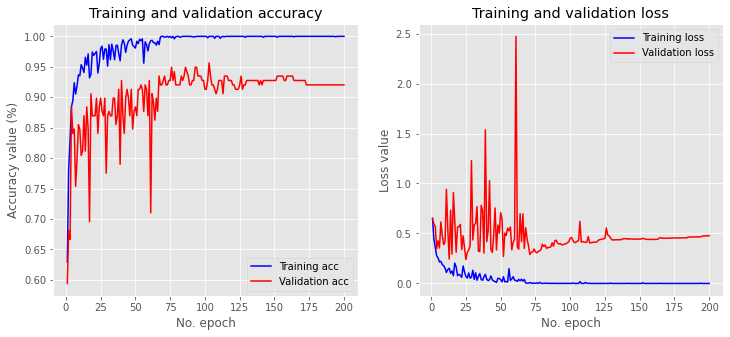

In [37]:
plot_history(history)

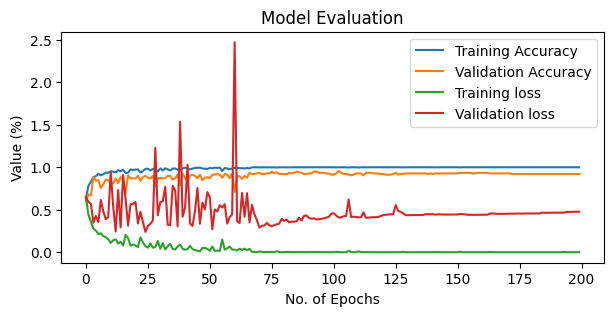

In [38]:
#All in one Graph (loss and accuracy)
plt.style.use('default')
plt.figure(figsize=(7, 3))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"]) 
plt.title("Model Evaluation")
plt.ylabel("Value (%)")
plt.xlabel("No. of Epochs")
plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation loss"])
plt.show()

In [42]:
#These confussion matrix are not correct
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test1 = np.argmax(y_test, axis=1)

print(accuracy_score(y_test1, y_pred))
#print(confusion_matrix(y_test,y_pred))
#print(classification_report(y_test,y_pred))

5/5 [==============================] - 0s 4ms/step
0.9202898550724637


### Graph Method for Mobinet

In [43]:
X_value = X_list_mob[0]
y_value = y_list[0]
labels = data_labels[0]
train_accs, test_accs = [], []

nclasses = y_value.shape[1]
nfolds = 10
nrepeats = 3
epochs = 200
batch_size = 32
learning_rate = 3e-3 #0.003
verbose = True

# Train and evaluate the model for each fold.
for train_index, test_index in tqdm(
    RepeatedStratifiedKFold(n_splits = nfolds, n_repeats = nrepeats, random_state = 0).split(X_value, labels), \
    total = nfolds*nrepeats, disable = not True #(verbose - True)
):

    # Select the data for this fold.
    X_train = tf.gather(X_value, train_index) 
    y_train = tf.gather(y_value, train_index)
    X_test = tf.gather(X_value, test_index)
    y_test = tf.gather(y_value, test_index)
    
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)
    
    #Define Model
    model = Sequential()
    model.add(Conv2D(filters = 16, kernel_size = (3,3), padding='same', input_shape=(2,2,320), activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(24, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(32, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(48, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Conv2D(64, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(1,1))
    model.add(Flatten())
    model.add(Dense(128,activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation="relu"))
    model.add(Dense(nclasses, activation="sigmoid"))

    #Learning Rate
    steps_per_epoch = math.ceil(len(X_train) / batch_size)
    third_of_total_steps = math.floor(epochs * steps_per_epoch / 3)
    
    # Train and evaluate the model.
    model.compile(
        optimizer=Adam(
            learning_rate=ExponentialDecay(
                learning_rate,
                decay_steps=third_of_total_steps,
                decay_rate=0.1,
                staircase=True
            )
        ),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    # Train the model on the training set and evaluate it on the test set.
    history = (model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, verbose=1, \
                         validation_data=(X_test, y_test)))
    train_loss, train_acc = model.evaluate(X_train, y_train, batch_size = batch_size, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, batch_size = batch_size, verbose=0)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# Aggregate.
results = {
    "Train_Acc": np.mean(train_accs),
    "Train_std": np.std(train_accs),
    "Test_Acc": np.mean(test_accs),
    "Test_std": np.std(test_accs)
}

# Report.
if verbose:
    print(
        tabulate(
            [
                ["Train", results["Train_Acc"], results["Train_std"]],
                ["Test", results["Test_Acc"], results["Test_std"]]
            ],
            headers=["Set", "Accuracy", "Standard Deviation"]
        )
    )

  0%|          | 0/30 [00:00<?, ?it/s]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 29ms/step - loss: 0.6429 - accuracy: 0.6455 - val_loss: 0.6392 - val_accuracy: 0.6403
Epoch 2/200
39/39 [==============================] - 1s 17ms/step - loss: 0.5295 - accuracy: 0.7209 - val_loss: 0.5811 - val_accuracy: 0.7122
Epoch 3/200
39/39 [==============================] - 1s 16ms/step - loss: 0.4603 - accuracy: 0.7706 - val_loss: 0.5543 - val_accuracy: 0.7338
Epoch 4/200
39/39 [==============================] - 1s 17ms/step - loss: 0.4341 - accuracy: 0.7979 - val_loss: 0.4813 - val_accuracy: 0.7626
Epoch 5/200
39/39 [==============================] - 1s 17ms/step - loss: 0.3769 - accuracy: 0.8228 - val_loss: 0.4059 - val_accuracy: 0.7698
Epoch 6/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3659 - accuracy: 0.8332 - val_loss: 0.4948 - val_accuracy: 0.7338
Epoch 7/200
39/39 [==============================] - 1s 18ms/step - loss: 0.3597 - accuracy: 0

  3%|▎         | 1/30 [03:05<1:29:34, 185.32s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 25ms/step - loss: 0.7138 - accuracy: 0.6087 - val_loss: 0.6806 - val_accuracy: 0.5396
Epoch 2/200
39/39 [==============================] - 1s 16ms/step - loss: 0.5257 - accuracy: 0.7233 - val_loss: 0.5960 - val_accuracy: 0.6763
Epoch 3/200
39/39 [==============================] - 1s 23ms/step - loss: 0.4678 - accuracy: 0.7418 - val_loss: 0.6055 - val_accuracy: 0.6331
Epoch 4/200
39/39 [==============================] - 1s 36ms/step - loss: 0.3919 - accuracy: 0.8043 - val_loss: 0.5807 - val_accuracy: 0.6547
Epoch 5/200
39/39 [==============================] - 1s 21ms/step - loss: 0.3667 - accuracy: 0.8332 - val_loss: 0.5252 - val_accuracy: 0.6763
Epoch 6/200
39/39 [==============================] - 1s 27ms/step - loss: 0.3387 - accuracy: 0.8428 - val_loss: 0.5149 - val_accuracy: 0.6906
Epoch 7/200
39/39 [==============================] - 1s 28ms/step - loss: 0.3543 - accuracy: 0

  7%|▋         | 2/30 [06:11<1:26:45, 185.90s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 39ms/step - loss: 0.6558 - accuracy: 0.6175 - val_loss: 0.6375 - val_accuracy: 0.6475
Epoch 2/200
39/39 [==============================] - 1s 21ms/step - loss: 0.5874 - accuracy: 0.6712 - val_loss: 0.6020 - val_accuracy: 0.6619
Epoch 3/200
39/39 [==============================] - 1s 29ms/step - loss: 0.4991 - accuracy: 0.7346 - val_loss: 0.5846 - val_accuracy: 0.6115
Epoch 4/200
39/39 [==============================] - 1s 25ms/step - loss: 0.4458 - accuracy: 0.7883 - val_loss: 0.5129 - val_accuracy: 0.7410
Epoch 5/200
39/39 [==============================] - 1s 37ms/step - loss: 0.4224 - accuracy: 0.7947 - val_loss: 0.4216 - val_accuracy: 0.7986
Epoch 6/200
39/39 [==============================] - 1s 30ms/step - loss: 0.3683 - accuracy: 0.8380 - val_loss: 0.4268 - val_accuracy: 0.7986
Epoch 7/200
39/39 [==============================] - 1s 33ms/step - loss: 0.3879 - accuracy: 0

 10%|█         | 3/30 [09:35<1:27:21, 194.13s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 28ms/step - loss: 0.7033 - accuracy: 0.6006 - val_loss: 0.6901 - val_accuracy: 0.4964
Epoch 2/200
39/39 [==============================] - 1s 22ms/step - loss: 0.5647 - accuracy: 0.6985 - val_loss: 0.6065 - val_accuracy: 0.7914
Epoch 3/200
39/39 [==============================] - 1s 29ms/step - loss: 0.4734 - accuracy: 0.7546 - val_loss: 0.5277 - val_accuracy: 0.7338
Epoch 4/200
39/39 [==============================] - 1s 27ms/step - loss: 0.4422 - accuracy: 0.7827 - val_loss: 0.4689 - val_accuracy: 0.7338
Epoch 5/200
39/39 [==============================] - 1s 21ms/step - loss: 0.3858 - accuracy: 0.8172 - val_loss: 0.4575 - val_accuracy: 0.7338
Epoch 6/200
39/39 [==============================] - 1s 22ms/step - loss: 0.3547 - accuracy: 0.8260 - val_loss: 0.5130 - val_accuracy: 0.8345
Epoch 7/200
39/39 [==============================] - 1s 22ms/step - loss: 0.3806 - accuracy: 0

 13%|█▎        | 4/30 [12:32<1:21:14, 187.49s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 32ms/step - loss: 0.6903 - accuracy: 0.6183 - val_loss: 0.6743 - val_accuracy: 0.5396
Epoch 2/200
39/39 [==============================] - 1s 17ms/step - loss: 0.5272 - accuracy: 0.7145 - val_loss: 0.6184 - val_accuracy: 0.7626
Epoch 3/200
39/39 [==============================] - 1s 30ms/step - loss: 0.4529 - accuracy: 0.7650 - val_loss: 0.5344 - val_accuracy: 0.7482
Epoch 4/200
39/39 [==============================] - 1s 22ms/step - loss: 0.4642 - accuracy: 0.7570 - val_loss: 0.5523 - val_accuracy: 0.7266
Epoch 5/200
39/39 [==============================] - 1s 26ms/step - loss: 0.3975 - accuracy: 0.7947 - val_loss: 0.4781 - val_accuracy: 0.7410
Epoch 6/200
39/39 [==============================] - 1s 25ms/step - loss: 0.3612 - accuracy: 0.8252 - val_loss: 0.5542 - val_accuracy: 0.7122
Epoch 7/200
39/39 [==============================] - 1s 26ms/step - loss: 0.3297 - accuracy: 0

 17%|█▋        | 5/30 [15:44<1:18:48, 189.13s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 26ms/step - loss: 0.6746 - accuracy: 0.6439 - val_loss: 0.6563 - val_accuracy: 0.7410
Epoch 2/200
39/39 [==============================] - 1s 36ms/step - loss: 0.5065 - accuracy: 0.7466 - val_loss: 0.6367 - val_accuracy: 0.5612
Epoch 3/200
39/39 [==============================] - 1s 34ms/step - loss: 0.4520 - accuracy: 0.7586 - val_loss: 0.4985 - val_accuracy: 0.7914
Epoch 4/200
39/39 [==============================] - 1s 22ms/step - loss: 0.4165 - accuracy: 0.7843 - val_loss: 0.6377 - val_accuracy: 0.6115
Epoch 5/200
39/39 [==============================] - 1s 22ms/step - loss: 0.3892 - accuracy: 0.7939 - val_loss: 0.4752 - val_accuracy: 0.7770
Epoch 6/200
39/39 [==============================] - 1s 22ms/step - loss: 0.3588 - accuracy: 0.8196 - val_loss: 0.3622 - val_accuracy: 0.8489
Epoch 7/200
39/39 [==============================] - 1s 22ms/step - loss: 0.3276 - accuracy: 0

 20%|██        | 6/30 [18:58<1:16:19, 190.82s/it]

(1248, 2, 2, 320)
(138, 2, 2, 320)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 30ms/step - loss: 0.6619 - accuracy: 0.6482 - val_loss: 0.6550 - val_accuracy: 0.5000
Epoch 2/200
39/39 [==============================] - 1s 13ms/step - loss: 0.4715 - accuracy: 0.7524 - val_loss: 0.6523 - val_accuracy: 0.4928
Epoch 3/200
39/39 [==============================] - 1s 24ms/step - loss: 0.4537 - accuracy: 0.7788 - val_loss: 0.5736 - val_accuracy: 0.6667
Epoch 4/200
39/39 [==============================] - 1s 24ms/step - loss: 0.4234 - accuracy: 0.7957 - val_loss: 0.4136 - val_accuracy: 0.8188
Epoch 5/200
39/39 [==============================] - 1s 24ms/step - loss: 0.3619 - accuracy: 0.8341 - val_loss: 0.4691 - val_accuracy: 0.7174
Epoch 6/200
39/39 [==============================] - 1s 22ms/step - loss: 0.3546 - accuracy: 0.8502 - val_loss: 0.5754 - val_accuracy: 0.8116
Epoch 7/200
39/39 [==============================] - 1s 22ms/step - loss: 0.3408 - accuracy: 0

 23%|██▎       | 7/30 [21:54<1:11:10, 185.69s/it]

(1248, 2, 2, 320)
(138, 2, 2, 320)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 18ms/step - loss: 0.7126 - accuracy: 0.6234 - val_loss: 0.6657 - val_accuracy: 0.6232
Epoch 2/200
39/39 [==============================] - 1s 15ms/step - loss: 0.5252 - accuracy: 0.7308 - val_loss: 0.6110 - val_accuracy: 0.7101
Epoch 3/200
39/39 [==============================] - 1s 22ms/step - loss: 0.4476 - accuracy: 0.7748 - val_loss: 0.5193 - val_accuracy: 0.7101
Epoch 4/200
39/39 [==============================] - 1s 21ms/step - loss: 0.3957 - accuracy: 0.7676 - val_loss: 0.4817 - val_accuracy: 0.7681
Epoch 5/200
39/39 [==============================] - 1s 25ms/step - loss: 0.4347 - accuracy: 0.7764 - val_loss: 0.5970 - val_accuracy: 0.7174
Epoch 6/200
39/39 [==============================] - 1s 26ms/step - loss: 0.4056 - accuracy: 0.8029 - val_loss: 0.4470 - val_accuracy: 0.7609
Epoch 7/200
39/39 [==============================] - 1s 26ms/step - loss: 0.3178 - accuracy: 0

 27%|██▋       | 8/30 [24:50<1:07:01, 182.81s/it]

(1248, 2, 2, 320)
(138, 2, 2, 320)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 23ms/step - loss: 0.6378 - accuracy: 0.6538 - val_loss: 0.6673 - val_accuracy: 0.6522
Epoch 2/200
39/39 [==============================] - 1s 23ms/step - loss: 0.5079 - accuracy: 0.7388 - val_loss: 0.6499 - val_accuracy: 0.5217
Epoch 3/200
39/39 [==============================] - 1s 23ms/step - loss: 0.4671 - accuracy: 0.7508 - val_loss: 0.6219 - val_accuracy: 0.6957
Epoch 4/200
39/39 [==============================] - 1s 21ms/step - loss: 0.4240 - accuracy: 0.7861 - val_loss: 0.5151 - val_accuracy: 0.7464
Epoch 5/200
39/39 [==============================] - 1s 22ms/step - loss: 0.4183 - accuracy: 0.8053 - val_loss: 0.5344 - val_accuracy: 0.6884
Epoch 6/200
39/39 [==============================] - 1s 29ms/step - loss: 0.3559 - accuracy: 0.8221 - val_loss: 0.6095 - val_accuracy: 0.6812
Epoch 7/200
39/39 [==============================] - 1s 22ms/step - loss: 0.3151 - accuracy: 0

 30%|███       | 9/30 [27:37<1:02:10, 177.65s/it]

(1248, 2, 2, 320)
(138, 2, 2, 320)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 26ms/step - loss: 0.6351 - accuracy: 0.6466 - val_loss: 0.7026 - val_accuracy: 0.5072
Epoch 2/200
39/39 [==============================] - 1s 17ms/step - loss: 0.4953 - accuracy: 0.7412 - val_loss: 0.6195 - val_accuracy: 0.6377
Epoch 3/200
39/39 [==============================] - 1s 25ms/step - loss: 0.4643 - accuracy: 0.7564 - val_loss: 0.6431 - val_accuracy: 0.7536
Epoch 4/200
39/39 [==============================] - 1s 26ms/step - loss: 0.4300 - accuracy: 0.7853 - val_loss: 0.4179 - val_accuracy: 0.7971
Epoch 5/200
39/39 [==============================] - 1s 24ms/step - loss: 0.3943 - accuracy: 0.7901 - val_loss: 0.5564 - val_accuracy: 0.6739
Epoch 6/200
39/39 [==============================] - 1s 27ms/step - loss: 0.3606 - accuracy: 0.8149 - val_loss: 0.8861 - val_accuracy: 0.6594
Epoch 7/200
39/39 [==============================] - 1s 29ms/step - loss: 0.3972 - accuracy: 0

 33%|███▎      | 10/30 [31:19<1:03:50, 191.52s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 18ms/step - loss: 0.6852 - accuracy: 0.6223 - val_loss: 0.6473 - val_accuracy: 0.5899
Epoch 2/200
39/39 [==============================] - 0s 12ms/step - loss: 0.5725 - accuracy: 0.6744 - val_loss: 0.6030 - val_accuracy: 0.7410
Epoch 3/200
39/39 [==============================] - 1s 23ms/step - loss: 0.4864 - accuracy: 0.7426 - val_loss: 0.5712 - val_accuracy: 0.6906
Epoch 4/200
39/39 [==============================] - 1s 27ms/step - loss: 0.4304 - accuracy: 0.7795 - val_loss: 0.4961 - val_accuracy: 0.7554
Epoch 5/200
39/39 [==============================] - 1s 30ms/step - loss: 0.4064 - accuracy: 0.8035 - val_loss: 0.4445 - val_accuracy: 0.7914
Epoch 6/200
39/39 [==============================] - 1s 27ms/step - loss: 0.3871 - accuracy: 0.8140 - val_loss: 0.4251 - val_accuracy: 0.8129
Epoch 7/200
39/39 [==============================] - 1s 29ms/step - loss: 0.3908 - accuracy: 0

 37%|███▋      | 11/30 [34:50<1:02:33, 197.55s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 18ms/step - loss: 0.7004 - accuracy: 0.6159 - val_loss: 0.6843 - val_accuracy: 0.5971
Epoch 2/200
39/39 [==============================] - 1s 13ms/step - loss: 0.5330 - accuracy: 0.7041 - val_loss: 0.6480 - val_accuracy: 0.6691
Epoch 3/200
39/39 [==============================] - 1s 25ms/step - loss: 0.4677 - accuracy: 0.7490 - val_loss: 0.6132 - val_accuracy: 0.7194
Epoch 4/200
39/39 [==============================] - 1s 29ms/step - loss: 0.4277 - accuracy: 0.7955 - val_loss: 0.4942 - val_accuracy: 0.7770
Epoch 5/200
39/39 [==============================] - 1s 29ms/step - loss: 0.4138 - accuracy: 0.7995 - val_loss: 0.6318 - val_accuracy: 0.6763
Epoch 6/200
39/39 [==============================] - 1s 30ms/step - loss: 0.3933 - accuracy: 0.8132 - val_loss: 0.4607 - val_accuracy: 0.7266
Epoch 7/200
39/39 [==============================] - 1s 28ms/step - loss: 0.3459 - accuracy: 0

 40%|████      | 12/30 [37:42<56:55, 189.76s/it]  

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 42ms/step - loss: 0.6968 - accuracy: 0.5910 - val_loss: 0.6963 - val_accuracy: 0.4964
Epoch 2/200
39/39 [==============================] - 1s 20ms/step - loss: 0.5820 - accuracy: 0.6856 - val_loss: 0.6913 - val_accuracy: 0.4532
Epoch 3/200
39/39 [==============================] - 1s 21ms/step - loss: 0.5139 - accuracy: 0.7177 - val_loss: 0.6101 - val_accuracy: 0.5540
Epoch 4/200
39/39 [==============================] - 1s 21ms/step - loss: 0.4564 - accuracy: 0.7859 - val_loss: 0.4169 - val_accuracy: 0.8201
Epoch 5/200
39/39 [==============================] - 1s 20ms/step - loss: 0.4332 - accuracy: 0.7971 - val_loss: 0.5269 - val_accuracy: 0.7338
Epoch 6/200
39/39 [==============================] - 1s 21ms/step - loss: 0.3866 - accuracy: 0.8164 - val_loss: 0.3851 - val_accuracy: 0.8417
Epoch 7/200
39/39 [==============================] - 1s 29ms/step - loss: 0.3812 - accuracy: 0

 43%|████▎     | 13/30 [40:00<49:15, 173.85s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 33ms/step - loss: 0.6600 - accuracy: 0.6351 - val_loss: 0.7452 - val_accuracy: 0.4964
Epoch 2/200
39/39 [==============================] - 1s 17ms/step - loss: 0.5315 - accuracy: 0.7249 - val_loss: 0.5883 - val_accuracy: 0.7050
Epoch 3/200
39/39 [==============================] - 1s 30ms/step - loss: 0.4285 - accuracy: 0.8003 - val_loss: 0.5554 - val_accuracy: 0.7698
Epoch 4/200
39/39 [==============================] - 1s 24ms/step - loss: 0.3821 - accuracy: 0.8212 - val_loss: 0.5708 - val_accuracy: 0.6547
Epoch 5/200
39/39 [==============================] - 1s 28ms/step - loss: 0.3496 - accuracy: 0.8404 - val_loss: 0.4734 - val_accuracy: 0.7122
Epoch 6/200
39/39 [==============================] - 1s 20ms/step - loss: 0.3348 - accuracy: 0.8396 - val_loss: 0.5318 - val_accuracy: 0.7914
Epoch 7/200
39/39 [==============================] - 1s 22ms/step - loss: 0.3418 - accuracy: 0

 47%|████▋     | 14/30 [42:39<45:13, 169.59s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 21ms/step - loss: 0.6873 - accuracy: 0.6087 - val_loss: 0.7212 - val_accuracy: 0.4964
Epoch 2/200
39/39 [==============================] - 0s 13ms/step - loss: 0.5280 - accuracy: 0.7249 - val_loss: 0.6307 - val_accuracy: 0.7122
Epoch 3/200
39/39 [==============================] - 0s 13ms/step - loss: 0.4472 - accuracy: 0.7747 - val_loss: 0.5705 - val_accuracy: 0.6978
Epoch 4/200
39/39 [==============================] - 0s 13ms/step - loss: 0.4237 - accuracy: 0.7915 - val_loss: 0.5146 - val_accuracy: 0.6763
Epoch 5/200
39/39 [==============================] - 0s 12ms/step - loss: 0.4217 - accuracy: 0.8091 - val_loss: 0.5261 - val_accuracy: 0.7266
Epoch 6/200
39/39 [==============================] - 0s 13ms/step - loss: 0.3694 - accuracy: 0.8340 - val_loss: 0.5642 - val_accuracy: 0.7482
Epoch 7/200
39/39 [==============================] - 0s 12ms/step - loss: 0.3381 - accuracy: 0

 50%|█████     | 15/30 [45:16<41:25, 165.72s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 35ms/step - loss: 0.6669 - accuracy: 0.6367 - val_loss: 0.6758 - val_accuracy: 0.6043
Epoch 2/200
39/39 [==============================] - 1s 20ms/step - loss: 0.5439 - accuracy: 0.7185 - val_loss: 0.6414 - val_accuracy: 0.5683
Epoch 3/200
39/39 [==============================] - 1s 30ms/step - loss: 0.4477 - accuracy: 0.7787 - val_loss: 0.5562 - val_accuracy: 0.7338
Epoch 4/200
39/39 [==============================] - 1s 29ms/step - loss: 0.4273 - accuracy: 0.7787 - val_loss: 0.5240 - val_accuracy: 0.7410
Epoch 5/200
39/39 [==============================] - 1s 17ms/step - loss: 0.3678 - accuracy: 0.8356 - val_loss: 0.4737 - val_accuracy: 0.7842
Epoch 6/200
39/39 [==============================] - 1s 20ms/step - loss: 0.3469 - accuracy: 0.8436 - val_loss: 0.4057 - val_accuracy: 0.7770
Epoch 7/200
39/39 [==============================] - 1s 26ms/step - loss: 0.3378 - accuracy: 0

 53%|█████▎    | 16/30 [49:00<42:46, 183.35s/it]

(1248, 2, 2, 320)
(138, 2, 2, 320)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 31ms/step - loss: 0.7415 - accuracy: 0.6010 - val_loss: 0.6768 - val_accuracy: 0.5000
Epoch 2/200
39/39 [==============================] - 0s 13ms/step - loss: 0.5533 - accuracy: 0.6899 - val_loss: 0.6186 - val_accuracy: 0.5797
Epoch 3/200
39/39 [==============================] - 1s 21ms/step - loss: 0.4847 - accuracy: 0.7628 - val_loss: 0.4850 - val_accuracy: 0.7754
Epoch 4/200
39/39 [==============================] - 1s 29ms/step - loss: 0.4242 - accuracy: 0.7981 - val_loss: 0.4834 - val_accuracy: 0.8043
Epoch 5/200
39/39 [==============================] - 1s 20ms/step - loss: 0.3996 - accuracy: 0.8061 - val_loss: 0.5189 - val_accuracy: 0.7246
Epoch 6/200
39/39 [==============================] - 1s 29ms/step - loss: 0.3722 - accuracy: 0.8149 - val_loss: 0.3953 - val_accuracy: 0.8261
Epoch 7/200
39/39 [==============================] - 1s 29ms/step - loss: 0.3287 - accuracy: 0

 57%|█████▋    | 17/30 [52:32<41:35, 192.00s/it]

(1248, 2, 2, 320)
(138, 2, 2, 320)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 18ms/step - loss: 0.6743 - accuracy: 0.6274 - val_loss: 0.6620 - val_accuracy: 0.6449
Epoch 2/200
39/39 [==============================] - 1s 19ms/step - loss: 0.5492 - accuracy: 0.7107 - val_loss: 0.5578 - val_accuracy: 0.7391
Epoch 3/200
39/39 [==============================] - 1s 27ms/step - loss: 0.5096 - accuracy: 0.7660 - val_loss: 0.5435 - val_accuracy: 0.7899
Epoch 4/200
39/39 [==============================] - 1s 28ms/step - loss: 0.4129 - accuracy: 0.8061 - val_loss: 0.5773 - val_accuracy: 0.6449
Epoch 5/200
39/39 [==============================] - 1s 28ms/step - loss: 0.3905 - accuracy: 0.8149 - val_loss: 0.4331 - val_accuracy: 0.7681
Epoch 6/200
39/39 [==============================] - 1s 26ms/step - loss: 0.3412 - accuracy: 0.8277 - val_loss: 0.4200 - val_accuracy: 0.7464
Epoch 7/200
39/39 [==============================] - 1s 27ms/step - loss: 0.3244 - accuracy: 0

 60%|██████    | 18/30 [55:29<37:28, 187.37s/it]

(1248, 2, 2, 320)
(138, 2, 2, 320)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 25ms/step - loss: 0.6686 - accuracy: 0.6154 - val_loss: 0.6818 - val_accuracy: 0.5290
Epoch 2/200
39/39 [==============================] - 1s 18ms/step - loss: 0.5488 - accuracy: 0.7163 - val_loss: 0.6597 - val_accuracy: 0.5580
Epoch 3/200
39/39 [==============================] - 1s 18ms/step - loss: 0.4751 - accuracy: 0.7684 - val_loss: 0.5597 - val_accuracy: 0.6812
Epoch 4/200
39/39 [==============================] - 1s 27ms/step - loss: 0.3973 - accuracy: 0.8061 - val_loss: 0.5010 - val_accuracy: 0.7464
Epoch 5/200
39/39 [==============================] - 1s 21ms/step - loss: 0.3578 - accuracy: 0.8373 - val_loss: 0.4921 - val_accuracy: 0.7681
Epoch 6/200
39/39 [==============================] - 1s 24ms/step - loss: 0.3609 - accuracy: 0.8381 - val_loss: 0.4780 - val_accuracy: 0.7609
Epoch 7/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3361 - accuracy: 0

 63%|██████▎   | 19/30 [58:09<32:50, 179.17s/it]

(1248, 2, 2, 320)
(138, 2, 2, 320)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 3s 32ms/step - loss: 0.6983 - accuracy: 0.5929 - val_loss: 0.7093 - val_accuracy: 0.5000
Epoch 2/200
39/39 [==============================] - 1s 16ms/step - loss: 0.5262 - accuracy: 0.7196 - val_loss: 0.6732 - val_accuracy: 0.5000
Epoch 3/200
39/39 [==============================] - 1s 20ms/step - loss: 0.4690 - accuracy: 0.7572 - val_loss: 0.6485 - val_accuracy: 0.5507
Epoch 4/200
39/39 [==============================] - 1s 20ms/step - loss: 0.4153 - accuracy: 0.8061 - val_loss: 0.6452 - val_accuracy: 0.5652
Epoch 5/200
39/39 [==============================] - 1s 20ms/step - loss: 0.3936 - accuracy: 0.8013 - val_loss: 0.8923 - val_accuracy: 0.6812
Epoch 6/200
39/39 [==============================] - 1s 20ms/step - loss: 0.3490 - accuracy: 0.8478 - val_loss: 1.0230 - val_accuracy: 0.6087
Epoch 7/200
39/39 [==============================] - 1s 17ms/step - loss: 0.3138 - accuracy: 0

 67%|██████▋   | 20/30 [1:01:18<30:21, 182.18s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 21ms/step - loss: 0.7200 - accuracy: 0.5870 - val_loss: 0.6764 - val_accuracy: 0.6259
Epoch 2/200
39/39 [==============================] - 1s 17ms/step - loss: 0.5025 - accuracy: 0.7073 - val_loss: 0.6124 - val_accuracy: 0.5612
Epoch 3/200
39/39 [==============================] - 1s 25ms/step - loss: 0.4658 - accuracy: 0.7378 - val_loss: 0.5534 - val_accuracy: 0.7266
Epoch 4/200
39/39 [==============================] - 1s 28ms/step - loss: 0.4098 - accuracy: 0.7939 - val_loss: 0.5034 - val_accuracy: 0.7770
Epoch 5/200
39/39 [==============================] - 1s 27ms/step - loss: 0.3614 - accuracy: 0.8115 - val_loss: 0.4611 - val_accuracy: 0.7194
Epoch 6/200
39/39 [==============================] - 1s 29ms/step - loss: 0.4436 - accuracy: 0.7979 - val_loss: 0.5602 - val_accuracy: 0.7194
Epoch 7/200
39/39 [==============================] - 1s 29ms/step - loss: 0.3393 - accuracy: 0

 70%|███████   | 21/30 [1:04:46<28:27, 189.73s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 20ms/step - loss: 0.6763 - accuracy: 0.6030 - val_loss: 0.6674 - val_accuracy: 0.5108
Epoch 2/200
39/39 [==============================] - 1s 14ms/step - loss: 0.5541 - accuracy: 0.7081 - val_loss: 0.5859 - val_accuracy: 0.6906
Epoch 3/200
39/39 [==============================] - 1s 28ms/step - loss: 0.4373 - accuracy: 0.7899 - val_loss: 0.5379 - val_accuracy: 0.6619
Epoch 4/200
39/39 [==============================] - 1s 33ms/step - loss: 0.4442 - accuracy: 0.8003 - val_loss: 0.5234 - val_accuracy: 0.7266
Epoch 5/200
39/39 [==============================] - 1s 30ms/step - loss: 0.3949 - accuracy: 0.8011 - val_loss: 0.5091 - val_accuracy: 0.7122
Epoch 6/200
39/39 [==============================] - 1s 30ms/step - loss: 0.3995 - accuracy: 0.8180 - val_loss: 0.4377 - val_accuracy: 0.7410
Epoch 7/200
39/39 [==============================] - 1s 31ms/step - loss: 0.3310 - accuracy: 0

 73%|███████▎  | 22/30 [1:08:29<26:39, 199.91s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 21ms/step - loss: 0.7104 - accuracy: 0.6143 - val_loss: 0.6794 - val_accuracy: 0.5252
Epoch 2/200
39/39 [==============================] - 1s 14ms/step - loss: 0.5627 - accuracy: 0.6905 - val_loss: 0.6362 - val_accuracy: 0.6547
Epoch 3/200
39/39 [==============================] - 1s 14ms/step - loss: 0.4794 - accuracy: 0.7490 - val_loss: 0.6043 - val_accuracy: 0.6187
Epoch 4/200
39/39 [==============================] - 1s 15ms/step - loss: 0.4414 - accuracy: 0.7811 - val_loss: 0.6727 - val_accuracy: 0.5827
Epoch 5/200
39/39 [==============================] - 1s 14ms/step - loss: 0.4344 - accuracy: 0.7706 - val_loss: 0.4786 - val_accuracy: 0.7338
Epoch 6/200
39/39 [==============================] - 1s 15ms/step - loss: 0.3762 - accuracy: 0.8268 - val_loss: 0.4719 - val_accuracy: 0.7698
Epoch 7/200
39/39 [==============================] - 1s 15ms/step - loss: 0.3693 - accuracy: 0

 77%|███████▋  | 23/30 [1:10:25<20:21, 174.50s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 3s 29ms/step - loss: 0.6826 - accuracy: 0.6014 - val_loss: 0.6614 - val_accuracy: 0.6115
Epoch 2/200
39/39 [==============================] - 1s 17ms/step - loss: 0.5402 - accuracy: 0.7153 - val_loss: 0.6174 - val_accuracy: 0.6475
Epoch 3/200
39/39 [==============================] - 0s 13ms/step - loss: 0.4768 - accuracy: 0.7570 - val_loss: 0.5510 - val_accuracy: 0.6906
Epoch 4/200
39/39 [==============================] - 0s 13ms/step - loss: 0.4350 - accuracy: 0.7899 - val_loss: 0.4995 - val_accuracy: 0.7770
Epoch 5/200
39/39 [==============================] - 1s 21ms/step - loss: 0.3831 - accuracy: 0.8140 - val_loss: 0.3906 - val_accuracy: 0.8201
Epoch 6/200
39/39 [==============================] - 1s 21ms/step - loss: 0.3542 - accuracy: 0.8404 - val_loss: 0.4925 - val_accuracy: 0.6619
Epoch 7/200
39/39 [==============================] - 1s 16ms/step - loss: 0.3677 - accuracy: 0

 80%|████████  | 24/30 [1:12:18<15:36, 156.12s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 21ms/step - loss: 0.7097 - accuracy: 0.6263 - val_loss: 0.6682 - val_accuracy: 0.5540
Epoch 2/200
39/39 [==============================] - 0s 13ms/step - loss: 0.5213 - accuracy: 0.7418 - val_loss: 0.6068 - val_accuracy: 0.6835
Epoch 3/200
39/39 [==============================] - 0s 12ms/step - loss: 0.4494 - accuracy: 0.7682 - val_loss: 0.5561 - val_accuracy: 0.7194
Epoch 4/200
39/39 [==============================] - 0s 12ms/step - loss: 0.4627 - accuracy: 0.7674 - val_loss: 0.5241 - val_accuracy: 0.7338
Epoch 5/200
39/39 [==============================] - 0s 12ms/step - loss: 0.4106 - accuracy: 0.7907 - val_loss: 0.4381 - val_accuracy: 0.7842
Epoch 6/200
39/39 [==============================] - 0s 12ms/step - loss: 0.3586 - accuracy: 0.8340 - val_loss: 0.3989 - val_accuracy: 0.7698
Epoch 7/200
39/39 [==============================] - 0s 12ms/step - loss: 0.3366 - accuracy: 0

 83%|████████▎ | 25/30 [1:14:08<11:51, 142.26s/it]

(1247, 2, 2, 320)
(139, 2, 2, 320)
(1247, 2)
(139, 2)
Epoch 1/200
39/39 [==============================] - 2s 23ms/step - loss: 0.6842 - accuracy: 0.6111 - val_loss: 0.6709 - val_accuracy: 0.4748
Epoch 2/200
39/39 [==============================] - 1s 16ms/step - loss: 0.5547 - accuracy: 0.7049 - val_loss: 0.5825 - val_accuracy: 0.7122
Epoch 3/200
39/39 [==============================] - 1s 16ms/step - loss: 0.5048 - accuracy: 0.7410 - val_loss: 0.5327 - val_accuracy: 0.7626
Epoch 4/200
39/39 [==============================] - 1s 16ms/step - loss: 0.4660 - accuracy: 0.7827 - val_loss: 0.4780 - val_accuracy: 0.7770
Epoch 5/200
39/39 [==============================] - 1s 15ms/step - loss: 0.4017 - accuracy: 0.8132 - val_loss: 0.7119 - val_accuracy: 0.6763
Epoch 6/200
39/39 [==============================] - 1s 13ms/step - loss: 0.3761 - accuracy: 0.8252 - val_loss: 0.4197 - val_accuracy: 0.8273
Epoch 7/200
39/39 [==============================] - 0s 12ms/step - loss: 0.3429 - accuracy: 0

 87%|████████▋ | 26/30 [1:16:41<09:42, 145.52s/it]

(1248, 2, 2, 320)
(138, 2, 2, 320)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 18ms/step - loss: 0.6869 - accuracy: 0.5921 - val_loss: 0.6821 - val_accuracy: 0.5000
Epoch 2/200
39/39 [==============================] - 0s 11ms/step - loss: 0.5774 - accuracy: 0.6771 - val_loss: 0.6144 - val_accuracy: 0.6232
Epoch 3/200
39/39 [==============================] - 1s 21ms/step - loss: 0.5019 - accuracy: 0.7436 - val_loss: 0.5281 - val_accuracy: 0.7174
Epoch 4/200
39/39 [==============================] - 1s 25ms/step - loss: 0.4422 - accuracy: 0.7941 - val_loss: 0.6858 - val_accuracy: 0.6522
Epoch 5/200
39/39 [==============================] - 1s 27ms/step - loss: 0.4024 - accuracy: 0.8125 - val_loss: 0.4388 - val_accuracy: 0.7754
Epoch 6/200
39/39 [==============================] - 1s 27ms/step - loss: 0.3706 - accuracy: 0.8229 - val_loss: 1.0248 - val_accuracy: 0.6522
Epoch 7/200
39/39 [==============================] - 1s 25ms/step - loss: 0.4076 - accuracy: 0

 90%|█████████ | 27/30 [1:19:56<08:01, 160.48s/it]

(1248, 2, 2, 320)
(138, 2, 2, 320)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 2s 20ms/step - loss: 0.6760 - accuracy: 0.6290 - val_loss: 0.6801 - val_accuracy: 0.5000
Epoch 2/200
39/39 [==============================] - 1s 18ms/step - loss: 0.5257 - accuracy: 0.7228 - val_loss: 0.6099 - val_accuracy: 0.7391
Epoch 3/200
39/39 [==============================] - 1s 31ms/step - loss: 0.4564 - accuracy: 0.7636 - val_loss: 0.5700 - val_accuracy: 0.5942
Epoch 4/200
39/39 [==============================] - 1s 33ms/step - loss: 0.4264 - accuracy: 0.7965 - val_loss: 0.5003 - val_accuracy: 0.7536
Epoch 5/200
39/39 [==============================] - 1s 33ms/step - loss: 0.3675 - accuracy: 0.8373 - val_loss: 0.4291 - val_accuracy: 0.7899
Epoch 6/200
39/39 [==============================] - 1s 32ms/step - loss: 0.3542 - accuracy: 0.8325 - val_loss: 0.4622 - val_accuracy: 0.7971
Epoch 7/200
39/39 [==============================] - 1s 31ms/step - loss: 0.3307 - accuracy: 0

 93%|█████████▎| 28/30 [1:22:47<05:27, 163.56s/it]

(1248, 2, 2, 320)
(138, 2, 2, 320)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 3s 26ms/step - loss: 0.6686 - accuracy: 0.6466 - val_loss: 0.6917 - val_accuracy: 0.5362
Epoch 2/200
39/39 [==============================] - 1s 15ms/step - loss: 0.5131 - accuracy: 0.7171 - val_loss: 0.6311 - val_accuracy: 0.6667
Epoch 3/200
39/39 [==============================] - 1s 17ms/step - loss: 0.4491 - accuracy: 0.7732 - val_loss: 0.5269 - val_accuracy: 0.7826
Epoch 4/200
39/39 [==============================] - 1s 18ms/step - loss: 0.4196 - accuracy: 0.8005 - val_loss: 0.9055 - val_accuracy: 0.5580
Epoch 5/200
39/39 [==============================] - 1s 17ms/step - loss: 0.3924 - accuracy: 0.8093 - val_loss: 0.4640 - val_accuracy: 0.7971
Epoch 6/200
39/39 [==============================] - 1s 20ms/step - loss: 0.3591 - accuracy: 0.8349 - val_loss: 0.5013 - val_accuracy: 0.7536
Epoch 7/200
39/39 [==============================] - 1s 21ms/step - loss: 0.3260 - accuracy: 0

 97%|█████████▋| 29/30 [1:25:24<02:41, 161.75s/it]

(1248, 2, 2, 320)
(138, 2, 2, 320)
(1248, 2)
(138, 2)
Epoch 1/200
39/39 [==============================] - 3s 30ms/step - loss: 0.6664 - accuracy: 0.6186 - val_loss: 0.6967 - val_accuracy: 0.5217
Epoch 2/200
39/39 [==============================] - 1s 20ms/step - loss: 0.5290 - accuracy: 0.7147 - val_loss: 0.6567 - val_accuracy: 0.5797
Epoch 3/200
39/39 [==============================] - 1s 20ms/step - loss: 0.4417 - accuracy: 0.7756 - val_loss: 0.6185 - val_accuracy: 0.6884
Epoch 4/200
39/39 [==============================] - 1s 17ms/step - loss: 0.4419 - accuracy: 0.7588 - val_loss: 0.5174 - val_accuracy: 0.7609
Epoch 5/200
39/39 [==============================] - 1s 23ms/step - loss: 0.3999 - accuracy: 0.8109 - val_loss: 0.4984 - val_accuracy: 0.7971
Epoch 6/200
39/39 [==============================] - 1s 26ms/step - loss: 0.3386 - accuracy: 0.8542 - val_loss: 0.4783 - val_accuracy: 0.7174
Epoch 7/200
39/39 [==============================] - 1s 25ms/step - loss: 0.3764 - accuracy: 0

100%|██████████| 30/30 [1:28:05<00:00, 176.19s/it]

Set      Accuracy    Standard Deviation
-----  ----------  --------------------
Train    1                     0
Test     0.830421              0.034582


In [44]:
# ploting graph by using values of last epoch for graphs
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend()

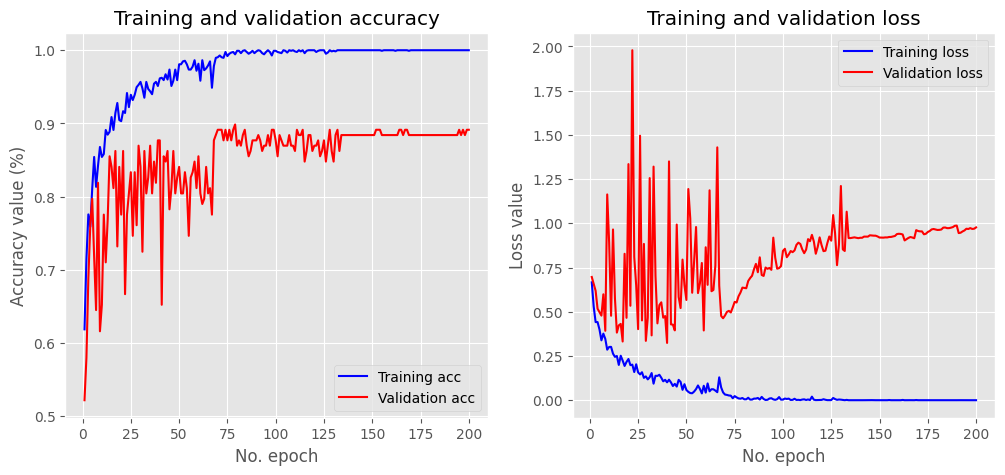

In [45]:
plot_history(history)

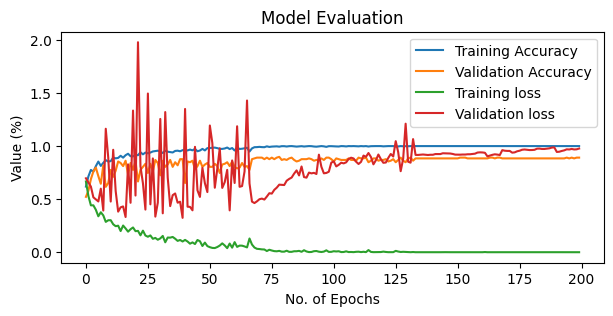

In [46]:
#All in one Graph (loss and accuracy)
plt.style.use('default')
plt.figure(figsize=(7, 3))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"]) 
plt.title("Model Evaluation")
plt.ylabel("Value (%)")
plt.xlabel("No. of Epochs")
plt.legend(["Training Accuracy","Validation Accuracy","Training loss","Validation loss"])
plt.show()

In [48]:
#These confussion matrix are not correct
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test1 = np.argmax(y_test, axis=1)

print(accuracy_score(y_test1, y_pred))
#print(confusion_matrix(y_test,y_pred))
#print(classification_report(y_test,y_pred))

5/5 [==============================] - 0s 5ms/step
0.8913043478260869
